In [1]:
from pyspark.sql import SparkSession

parquet_file_path = "XXXXXX"


df = spark.read.parquet(parquet_file_path)



## Data-Cleaning

In [5]:

from pyspark.sql.functions import from_unixtime
df_updated = df.withColumn("timestamp_created", from_unixtime("timestamp_created"))




In [6]:
from pyspark.sql.functions import when

df_updated = df_updated.withColumn(
    "language", 
    when(df_updated["language"] == "schinese", "chinese").otherwise(df_updated["language"])
)


In [7]:
df_updated = df_updated.withColumn(
    "language", 
    when(df_updated["language"] == "koreana", "korean").otherwise(df_updated["language"])
)


In [26]:
from pyspark.sql.functions import count, isnan


null_counts = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])



## Visualization of the Count of Nulls 

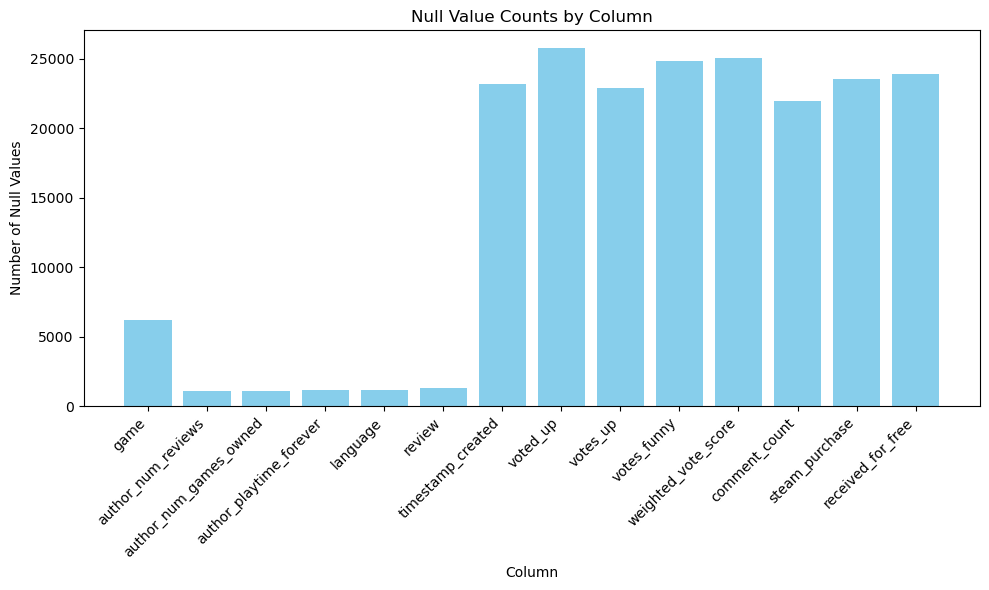

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

null_counts_pandas = null_counts.toPandas()


null_counts_pandas = null_counts_pandas.T.reset_index()
null_counts_pandas.columns = ['Column', 'Null_Count']

plt.figure(figsize=(10, 6))
plt.bar(null_counts_pandas['Column'], null_counts_pandas['Null_Count'], color='skyblue')

plt.title('Null Value Counts by Column')
plt.xlabel('Column')
plt.ylabel('Number of Null Values')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## More Cleaning

In [28]:
df_updated = df_updated.dropna(subset=['review'])


In [29]:
df_updated = df_updated.dropna(subset=['language'])


In [10]:
df_cleaned = df_updated.na.drop()


In [14]:
from pyspark.sql.functions import year

df_with_year = df_cleaned.withColumn("year", year(df_cleaned["timestamp_created"]))




In [15]:
df_filtered = df_with_year.filter(year(df_with_year["timestamp_created"]) <= 2024)

# Show the resulting DataFrame
df_filtered.show(5)



+---------+------------------+----------------------+-----------------------+--------+----------------------------------+-------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+----+
|     game|author_num_reviews|author_num_games_owned|author_playtime_forever|language|                            review|  timestamp_created|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|year|
+---------+------------------+----------------------+-----------------------+--------+----------------------------------+-------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+----+
|Stellaris|                 5|                   318|                  34545| english|              Stelleris is one ...|2018-07-22 11:50:50|       1|       0|          0|                0.0|            0|             1|                0|2018|
|Stellaris|             

## Word Count Visualization

In [21]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

columns = ["review"]


df_words = df_cleaned.withColumn("word", F.explode(F.split(F.col("review"), " ")))

word_count = df_words.groupBy("word").agg(F.count("*").alias("count"))

word_count_sorted = word_count.orderBy(F.desc("count"))

word_count_sorted.show()


+----+--------+
|word|   count|
+----+--------+
|    |83342328|
| the|66241043|
|   a|47649932|
| and|46604543|
|  to|43477156|
|game|33954497|
|  of|31345267|
|  is|31177617|
|   I|28076022|
| you|23179773|
+----+--------+
only showing top 10 rows



## Visualization of Reviews Counts by Language

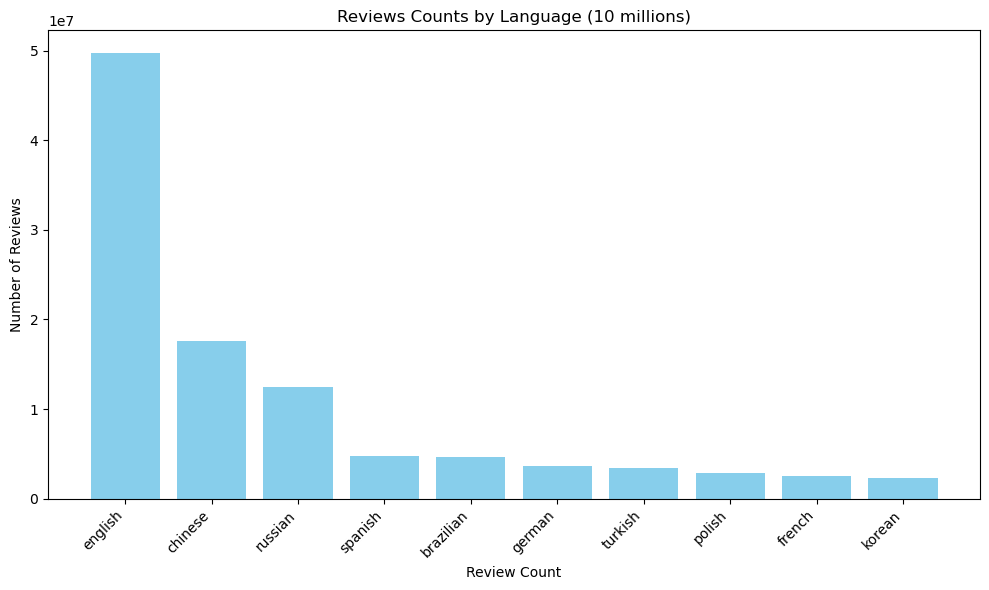

In [31]:
from pyspark.sql.functions import count

grouped_df = df_cleaned.groupBy("language") \
    .agg(count("review").alias("review_count"))

top_10_languages = grouped_df.orderBy("review_count", ascending=False).limit(10)
import matplotlib.pyplot as plt
import pandas as pd

top_10_languages = top_10_languages.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(top_10_languages['language'], top_10_languages['review_count'], color='skyblue')
plt.title('Reviews Counts by Language (10 millions)')
plt.xlabel('Review Count')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Visualization Relationship Plot  of Votes Up vs Weighted Score

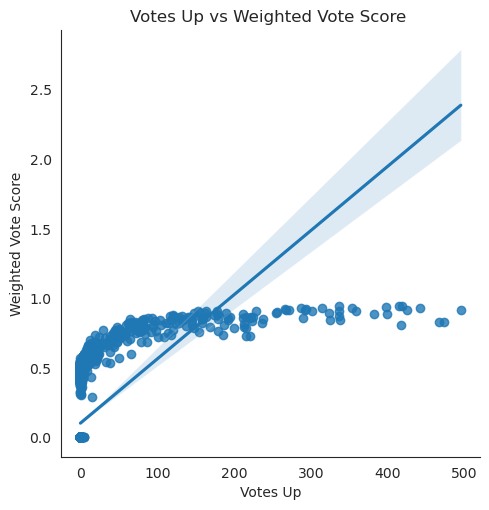

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the checkpointed Parquet files
checkpoint_path = "XXXXX"

# Read the checkpointed data back into a DataFrame
restored_df = spark.read.parquet(checkpoint_path)


# Convert to a Pandas DataFrame
df = restored_df.select('votes_up', 'weighted_vote_score').limit(100000).toPandas()

# Filter the DataFrame
filtered_df = df[df['votes_up'] <= 500]

# Set the style for Seaborn plots
sns.set_style("white")

# Create the relationship plot
lp = sns.lmplot(x='votes_up', y='weighted_vote_score', data=filtered_df)

# Add title and labels
lp.set(title="Votes Up vs Weighted Vote Score ", 
       xlabel="Votes Up", 
       ylabel="Weighted Vote Score")

# Save the plot
#plt.savefig("votes_vs_weighted_score_filtered.png")

# Show the plot
plt.show()
